# Imports and Materials

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import numpy as np
import pmag as pm
import tidy3d as td
import matplotlib.pyplot as plt
from jmaps.journey import *
td.config.logging_level = "ERROR"
material_list = ['diamond', 'nitride']
if 'mats' in dir() and np.all([m in mats for m in material_list]):
    print("mats already defined")
else:
    mats = pm.materials.init_materials(material_list, plot=False)

materials_env = JEnv('materials', {
    'material_list' : JSet(material_list),
})


Initializing diamond material
Initializing nitride material


# Pipeline Tools

# Journey

## Journey Init

In [2]:
layer_mats = ['diamond']


idler_wavelength = 1.31
n_idler = [mats[mat].nk_model(td.C_0/idler_wavelength)[0] for mat in layer_mats]
layer_heights = [idler_wavelength/n_idler[i]/len(layer_mats) for i in range(len(layer_mats))]

min_width = 0.25
max_width = 0.65
num_widths = 10
swept_layer_widths = [np.linspace(min_width, max_width, num_widths) for _ in range(len(layer_mats))]

# Mixer parameters
wl_min = 0.6
wl_max = 2.4
f_min = td.C_0 / wl_max
f_max = td.C_0 / wl_min
num_freqs=26
freqs = np.linspace(f_min, f_max, num_freqs)
mixer_env = JEnv('mixer', {
    'layer_heights' :      JVar(np.array(layer_heights)),
    'swept_layer_widths' : JVar(np.array(swept_layer_widths)),
    'chosen_layer_i' :     JSet(0),
    'num_modes' :          JSet(5),
    'freqs' :              JSet(freqs),
    'plotted_modes' :      JOpt(2),
    'plot_fields' :        JOpt(False),
    'plot_freq' :          JOpt(freqs[-1]),
})

mode_env = JEnv('mode', {
    'layer_mats' :       JSet(layer_mats),
    'bend_radius' :      JSet(0),
    'box_mat' :          JSet('air'),
    'cladding' :         JSet('air'),
    'target_neff' :      JSet(None),
    'web_modes' :        JSet(False),
    'plot_geom' :        JOpt(False),
    'material_library' : JOpt(mats),
    'return_fields' :    JOpt(False),
})

journey = Journey('nonlinear_dev', envs=[mixer_env, mode_env, materials_env])
print(journey)


Journey(nonlinear_dev)
Environments:
   mixer:
      layer_heights (VAR)
      swept_layer_widths (VAR)
      chosen_layer_i (SET)
      num_modes (SET)
      freqs (SET)
      plotted_modes (OPT)
      plot_fields (OPT)
      plot_freq (OPT)
   mode:
      layer_mats (SET)
      bend_radius (SET)
      box_mat (SET)
      cladding (SET)
      target_neff (SET)
      web_modes (SET)
      plot_geom (OPT)
      material_library (OPT)
      return_fields (OPT)
   materials:
      material_list (SET)
Paths:



## Path - Neff matching

In [3]:
class NeffPath(JPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return "neff"
    @property
    def env_names(self) -> list[str]:
        """List of required environment names"""
        return ['mixer', 'mode', 'materials']
    def _run(self, envs: dict[str, JEnv], verbose: bool=False):
        return pm.nonlinear.get_neff_mixer(**envs['mixer'].get_stripped_params(), mode_args=envs['mode'].get_stripped_params())
mixer_path = NeffPath()
journey.add_path(mixer_path)
print(journey)

Journey(nonlinear_dev)
Environments:
   mixer:
      layer_heights (VAR)
      swept_layer_widths (VAR)
      chosen_layer_i (SET)
      num_modes (SET)
      freqs (SET)
      plotted_modes (OPT)
      plot_fields (OPT)
      plot_freq (OPT)
   mode:
      layer_mats (SET)
      bend_radius (SET)
      box_mat (SET)
      cladding (SET)
      target_neff (SET)
      web_modes (SET)
      plot_geom (OPT)
      material_library (OPT)
      return_fields (OPT)
   materials:
      material_list (SET)
Paths:
   neff: 'mixer', 'mode', 'materials'



In [4]:
n_mixer = journey.run_path('neff', verbose=True)

Loaded path results from cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/nonlinear_dev/neff/c9330b074cf41f4739c0ae92d57ca4115c6698ee23b4d4cbdebcf048e61cd0b9.dill


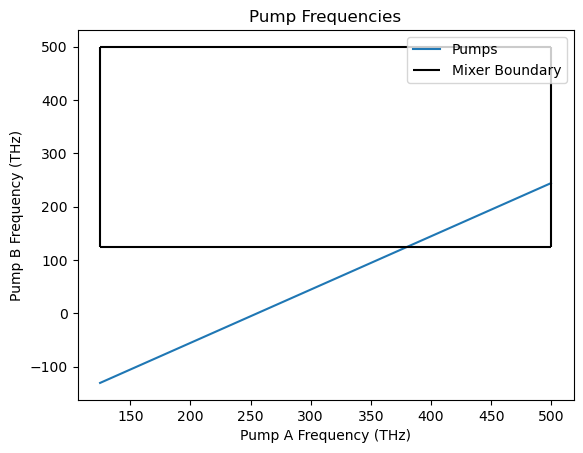

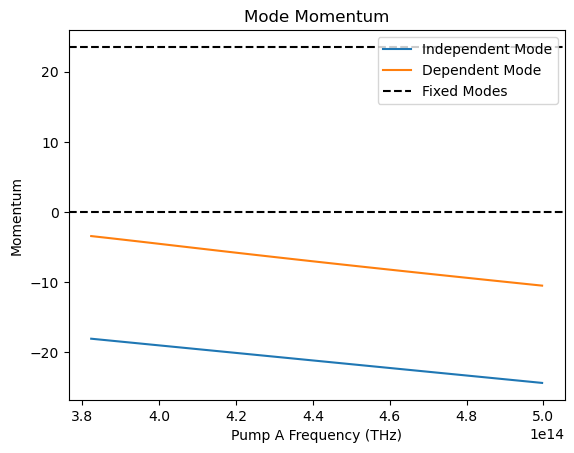

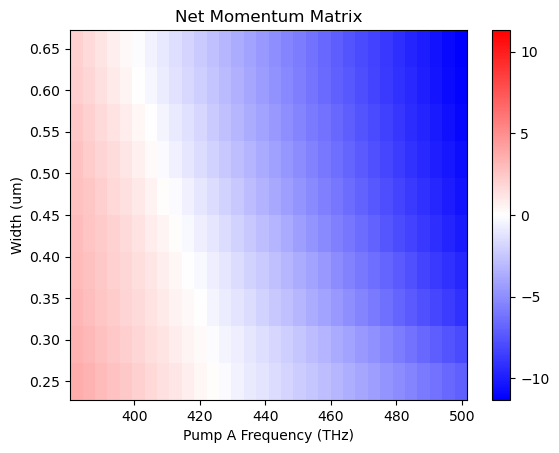

In [5]:
mode_factors = np.array([1, -1, -1, 1])
unit_ks  = np.array([1,  0,  1,-1])
fixed_freqs = td.C_0/np.array([0.619, 1.31])

f_A, f_B, net_momentum_matrix = n_mixer.net_momentum_matrix(fixed_freqs, mode_factors, mode_nums=0, unit_ks=unit_ks, 
                                                            fit_tol=1e-3, poly_order=10, plot=True, center_colorbar=True)